In [1]:
%load_ext autoreload
%autoreload 2

import random
import time
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="3"


import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import AdamW, Adam

import activation
import cpn_model
import config
import lesion
import michaels_load
import mRNN
import observer
import stim
import stim_model
import utils


OBSERVER_TYPE = observer.ObserverType.gaussian
STIMULATION_TYPE = stim.StimulationType.gaussian_exp
CPN_ACTIVATION_TYPE = activation.ActivationType.Tanh
EN_ACTIVATION_TYPE = activation.ActivationType.Tanh
LESION_TYPE = lesion.LesionType.connection
OBS_OUT_DIM = 20
OBS_SIGMA = 1.75
NUM_STIM_CHANNELS = 16
STIM_SIGMA = 2.175
BATCH_SIZE = 128
KFOLDS = 5
CUDA = torch.device(0)

LESION_ARGS = ([
    # No F5->M1
    (1, 2, 0, 1),
    # No M1->F5
    (0, 1, 1, 2),
],)

observer, stimulus, lesion_instance, en_activation, cpn_activation, \
        run_type_str, run_type_str_short, _ = config.get(observer_type=OBSERVER_TYPE,
                                              stimulation_type=STIMULATION_TYPE,
                                              lesion_type=LESION_TYPE,
                                              lesion_args=LESION_ARGS,
                                              en_activation_type=EN_ACTIVATION_TYPE,
                                              cpn_activation_type=CPN_ACTIVATION_TYPE,
                                              batch_size=BATCH_SIZE,
                                              num_stim_channels=NUM_STIM_CHANNELS,
                                              stim_sigma=STIM_SIGMA,
                                              obs_out_dim=OBS_OUT_DIM,
                                              obs_sigma=OBS_SIGMA,
                                              cuda=CUDA)


MODEL_OUT_DIR = "models"
LOG_OUT_DIR = "logs"

print("Run config:", run_type_str)
print(run_type_str_short)

Run config: gaussian20.1.75_connectionsIdxs[(1, 2, 0, 1), (0, 1, 1, 2)]_gaussianExp16.2.175_enActTanh_cpnActTanh
obsgaussian20_lesionconnection_stimgaussian_exp16_enActTanh_cpnActTanh


In [2]:
# Set up the Michaels mRNN

# Our stimulation model
stimulus.reset(batch_size=BATCH_SIZE)

mike = mRNN.MichaelsRNN(init_data_path=michaels_load.get_default_path(),
                       stimulus=stimulus)

if CUDA:
    mike.cuda()

mike.set_lesion(lesion_instance)


In [3]:
# Get the Michaels session data
dataset = mRNN.MichaelsDataset(michaels_load.get_default_path(),
    cuda=CUDA)

probs = torch.ones(len(dataset)) / float(len(dataset))
holdout_count = int(len(dataset) / KFOLDS)
holdout_idxs = set([p.item() for p in probs.multinomial(num_samples=holdout_count)])

train = []
test = []
for idx in range(len(dataset)):
    if idx in holdout_idxs:
        test.append(dataset[idx])
    else:
        train.append(dataset[idx])

# We have two loaders, since they maintain a little bit of state,
# and we nest EN training inside CPN training
loader_train = DataLoader(
  train, batch_size=len(train), shuffle=True,
)
loader_test = DataLoader(
  test, batch_size=len(test), shuffle=True,
)

torch.Size([341, 21])
torch.Size([1, 341, 50])
torch.Size([1, 341, 50])


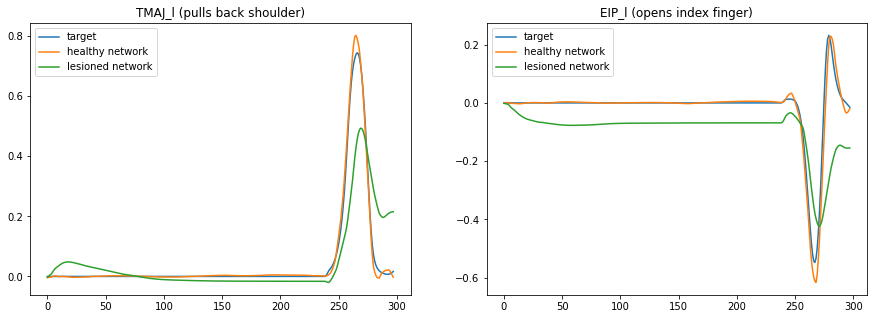

In [4]:
# Just some choice of examples, for graphical comparison
example_idx = random.randrange(len(dataset))
example_din, _, trial_len, example_dout = dataset[example_idx]

mike.set_lesion(None)
mike.reset()
reference_pred_healthy = mike.unroll(example_din.T)

# Lesion the network as we specified above
mike.set_lesion(lesion_instance)
mike.reset()
reference_pred_lesioned = mike.unroll(example_din.T)
mike.reset()


print(example_din.shape)
print(reference_pred_healthy.shape)
print(reference_pred_lesioned.shape)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].set_title("TMAJ_l (pulls back shoulder)")
ax[0].plot(example_dout[:trial_len, 7].cpu().detach().numpy(), label="target")
ax[0].plot(reference_pred_healthy[0, :trial_len, 7].cpu().detach().numpy(), label="healthy network")
ax[0].plot(reference_pred_lesioned[0, :trial_len, 7].cpu().detach().numpy(), label="lesioned network")
ax[0].legend(loc="upper left")
ax[1].set_title("EIP_l (opens index finger)")
ax[1].plot(example_dout[:trial_len, 45].cpu().detach().numpy(), label="target")
ax[1].plot(reference_pred_healthy[0, :trial_len, 45].cpu().detach().numpy(), label="healthy network")
ax[1].plot(reference_pred_lesioned[0, :trial_len, 45].cpu().detach().numpy(), label="lesioned network")
ax[1].legend(loc="upper left")

plt.show()

tensor(0.0006, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0207, device='cuda:0', grad_fn=<MseLossBackward>)


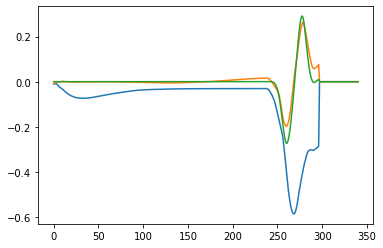

In [5]:
# Now a numerical comparison
comp_loss = torch.nn.MSELoss()

loader_comp = DataLoader(
  dataset, batch_size=len(dataset), shuffle=True
)
for s in loader_comp:
    din, trial_end, _, dout = s

comp_preds_healthy = torch.zeros((len(dataset), dataset.sample_len, reference_pred_healthy.shape[-1]))
if CUDA:
    comp_preds_healthy = comp_preds_healthy.cuda(CUDA)
    
mike.set_lesion(None)
mike.reset()
for tidx in range(din.shape[1]):
    cur_din = din[:, tidx, :].T
    p = mike(cur_din)
    comp_preds_healthy[:, tidx, :] = p[:, :]
comp_preds_healthy = utils.trunc_to_trial_end(comp_preds_healthy, trial_end)
comp_loss_healthy = comp_loss(comp_preds_healthy, dout)
print(comp_loss_healthy)

comp_preds_lesioned = torch.zeros((len(dataset), dataset.sample_len, reference_pred_healthy.shape[-1]))
if CUDA:
    comp_preds_lesioned = comp_preds_lesioned.cuda(CUDA)
mike.set_lesion(lesion_instance)
mike.reset()
reference_pred_lesioned = mike.unroll(example_din.T)
mike.reset()
for tidx in range(din.shape[1]):
    cur_din = din[:, tidx, :].T
    p = mike(cur_din)
    comp_preds_lesioned[:, tidx, :] = p[:, :]
comp_preds_lesioned = utils.trunc_to_trial_end(comp_preds_lesioned, trial_end)
comp_loss_lesioned = comp_loss(comp_preds_lesioned, dout)
print(comp_loss_lesioned)


plt.plot(comp_preds_lesioned[0, :, 20].cpu().detach().numpy())
plt.plot(comp_preds_healthy[0, :, 20].cpu().detach().numpy())
plt.plot(dout[0, :, 20].cpu().detach().numpy())
plt.show()


In [6]:
def unroll(cpn, mike, en, din, trial_end, observer,
           drop_module_idx=None, retain_stim_grads=False,
           cuda=None):
    batch_size = din.shape[0]
    steps = din.shape[1]
    obs_dim = 3 * observer.out_dim

    stims = []
    preds = torch.zeros(batch_size, steps - 1, en.out_dim)
    actuals = torch.zeros(batch_size, steps - 1, en.out_dim)

    if cuda is not None:
        preds = preds.cuda(cuda)
        actuals = actuals.cuda(cuda)

    # This is the actual, which EN predicts
    mike_out = mike(din[:, 0, :].T)

    for tidx in range(steps - 1):
        obs = mike.observe(observer, drop_module_idx=drop_module_idx)
        new_obs_cpn = torch.cat(obs, axis=1).detach()
        new_obs_en = obs[0].detach()

        # cpn recieves (obs, trial_end)
        cpn_in = torch.cat((new_obs_cpn, trial_end[:, tidx, :]), axis=1)
        # output is (batch_size, num_stim_channels)
        new_stim = cpn(cpn_in)
        assert new_stim.shape == (batch_size, mike.stimulus.num_stim_channels)
        if retain_stim_grads:
            new_stim.retain_grad()
        stims.append(new_stim)

        # en receives (obs, stims, trial_end)
        en_in = torch.cat((new_obs_en, new_stim, trial_end[:, tidx, :]), axis=1)
        cur_pred = en(en_in)
        preds[:, tidx, :] = cur_pred[:, :]

        # new_stim will be cloned in here, to prevent accidentally backprop-ing
        # through the "brain", aka mike.
        mike.stimulate(new_stim)

        # Note that 'preds' lags 'actual' by a time step, hence
        # 'pred' is a prediction of the actual en activity
        mike_out = mike(din[:, tidx + 1, :].T)
        actuals[:, tidx, :] = mike_out[:, :]

    actuals = utils.trunc_to_trial_end(actuals, trial_end[:, :-1, :])
    preds = utils.trunc_to_trial_end(preds, trial_end[:, :-1, :])
    return actuals, preds, stims

In [23]:
def train_an_en(mike, observer, cpn, data_loader, en=None,
                last_loss=1, drop_module_idx=None, losses=None,
                cuda=None):
    # the last EN we were working on training, for easy access
    global recent_en

    obs_dim = observer.out_dim * 1
    # Stim: mike.stimulus.num_stim_channels
    # +1 for trial_end
    en_in_dim = obs_dim + mike.stimulus.num_stim_channels + 1
    if en is None:
        en = stim_model.StimModelLSTM(en_in_dim, mike.output_dim,
                num_neurons=en_in_dim+50, activation_func=torch.nn.Tanh,
                cuda=cuda)

        if cuda is not None:
            en.cuda(cuda)

        recent_en = en
    vl = torch.tensor(1.0)
    opt_en = AdamW(en.parameters(), lr=9e-3, weight_decay=0.04)

    checkpoint_eidx = 0
    eidx = -1
    while True:
        for batch in data_loader:
            din, trial_end, trial_len, dout = batch
            batch_size = din.shape[0]
            steps = din.shape[1]
            eidx += 1
            opt_en.zero_grad()
            mike.reset()
            en.reset()
            cpn.reset()
            loss = torch.nn.MSELoss()

            for p in opt_en.param_groups:
                #if eidx < 3:
                #    p['lr'] = 2e-2
                if vl.item() < 0.0007:
                    p['lr'] = 1e-4
                elif vl.item() < 0.005:
                    p['lr'] = 3e-3
                else:
                    p['lr'] = 4e-3

            cpn_noise = cpn_model.CPNNoiseyLSTMCollection(cpn,
                                                          noise_var=2*(last_loss), 
                                                          #noisey_pct=0.8,
                                                          white_noise_pct=0.3,
                                                          white_noise_var=6,
                                                          cuda=cuda)

            # Just in case...
            for param in mike.parameters():
                param.requires_grad=False

            actual, preds, _ = unroll(cpn_noise, mike, en, din, trial_end,
                                      observer, drop_module_idx=drop_module_idx,
                                      cuda=cuda)

            # Update en
            rl = loss(preds, actual)
            rl.backward()
            opt_en.step()

            # Verify against the actual CPN
            if (eidx % 10) == 0:
                mike.reset()
                en.reset()
                cpn.reset()
                loss = torch.nn.MSELoss()
                actual_val, preds_val, _ = unroll(cpn, mike, en, din,
                                                  trial_end, observer,
                                                  drop_module_idx=drop_module_idx,
                                                  cuda=cuda)

                vl = loss(preds_val, actual_val)
                
            print("en", eidx, rl.item(), "val:", vl.item())
            if losses is not None:
                losses.append((rl.item(), vl.item()))

            if torch.isnan(vl) or torch.isinf(vl) or vl.item() > 1.5 or (eidx - checkpoint_eidx) > 5000:
                # Emergency eject button
                en = stim_model.StimModelLSTM(en.in_dim, en.out_dim, num_neurons=en.num_neurons,
                                       activation_func=en.activation_func_t)

                if cuda is not None:
                    en.cuda(cuda)

                recent_en = en
                opt_en = AdamW(en.parameters(), lr=1e-3, weight_decay=0.04)
                checkpoint_eidx = eidx

            if (vl.item() < max(0.02 * last_loss, 0.0003) and eidx > 100) or (eidx - checkpoint_eidx) == 2000:
                done = True
                break
            else:
                done = False

        if done:
            break

    opt_en.zero_grad()
    return en

In [25]:
obs_dim = observer.out_dim * 3
# +1 for trial_end
cpn_in_dim = obs_dim + 1
#cpn = cpn_model.CPNModelLSTM(cpn_in_dim, mike.stimulus.num_stim_channels,
#                             num_neurons=cpn_in_dim, activation_func=torch.nn.Tanh,
#                             cuda=CUDA)


#cpn.load_state_dict(torch.load('min_cpn_F5condrop_obs20_stim16_enWhiteNoiseOnly))

#opt_cpn = AdamW(cpn.parameters(), lr=5e-6)

#model_uuid = cpn.uuid
#latest_out_path = os.path.join(MODEL_OUT_DIR, f"latest_cpn_{run_type_str_short}_{model_uuid}")
#min_out_path = os.path.join(MODEL_OUT_DIR, f"min_cpn_{run_type_str_short}_{model_uuid}")
#log_out_path = os.path.join(LOG_OUT_DIR, f"{run_type_str_short}_{model_uuid}")

print(model_uuid)
print(latest_out_path)
print(min_out_path)
print(log_out_path)

loss = torch.nn.MSELoss()
rli = 0.0018

#cpn_losses = []
#en_train_losses = []
#en_train_epochs = []
#pred_losses = []
#real_losses = []
#test_losses = []
#super_epoch_count = 0
#en = None
#eidx = 0
while True:
    super_epoch_count += 1
    
    utils.write_train_logs(log_out_path, cpn=cpn_losses, pred=pred_losses,
                               task=real_losses, test=test_losses,
                               en_train=en_train_losses, en_train_epochs=en_train_epochs)

    for param in cpn.parameters():
        param.requires_grad=False

    en_train_losses.append([])
    en = train_an_en(mike, observer, cpn, loader_train, last_loss=rli, losses=en_train_losses[-1],
                     cuda=CUDA)
    en_train_epochs.append(eidx)

    for param in cpn.parameters():
        param.requires_grad=True
    for param in en.parameters():
        param.requires_grad=False
    for param in mike.parameters():
        param.requires_grad=False

    recent_losses = []
    num_regressed = 0
    while True:
        for batch in loader_train:
            eidx += 1
            opt_cpn.zero_grad()
            cpn.reset()
            en.reset()
            mike.reset()

            if rli >= 0.008:
                for p in opt_cpn.param_groups:
                    p['lr'] = 1e-3
            elif rli >= 0.006:
                for p in opt_cpn.param_groups:
                    p['lr'] = 5e-5
            elif rli >= 0.002:
                for p in opt_cpn.param_groups:
                    p['lr'] = 2e-6
            else:
                for p in opt_cpn.param_groups:
                    p['lr'] = 1e-6

            din, trial_end, trial_len, dout = batch
            batch_size = din.shape[0]
            steps = din.shape[1]
            
            
            # Test
            cpn.reset()
            opt_cpn.zero_grad()
            en.reset()
            mike.reset()
            batch_test = next(iter(loader_test))
            din_test, trial_end_test, trial_len_test, dout_test = batch_test
            batch_size_test = din_test.shape[0]
            steps_test = din_test.shape[1]
            actuals_test, preds_test, stims_test = unroll(cpn, mike, en, din_test,
                                           trial_end_test, observer, cuda=CUDA)

            rl_test = loss(actuals_test, dout_test[:, 1:, :])
            rli_test = rl_test.item()
            test_losses.append(rli_test)

            # Train
            cpn.reset()
            opt_cpn.zero_grad()
            en.reset()
            mike.reset()
            actuals, preds, stims = unroll(cpn, mike, en, din, trial_end, observer,
                                           retain_stim_grads=True,
                                           cuda=CUDA)
            preds.retain_grad()

            rl = loss(preds, dout[:, 1:, :])
            rli = rl.item()
            rl.backward()

            cpn_losses.append(rli)

            real_loss = torch.nn.MSELoss()(actuals, dout[:, 1:, :]).item()
            real_losses.append(real_loss)

            pred_loss = torch.nn.MSELoss()(preds, actuals).item()
            pred_losses.append(pred_loss)

            
            print("cpn", eidx, rl.item(),
                  "en loss:", pred_loss,
                  "actual task loss:", real_loss,
                   "test loss:", rli_test)
            recent_losses.append(real_loss)

            torch.save(cpn.state_dict(), latest_out_path)
            if real_loss == min(real_losses):
                torch.save(cpn.state_dict(), min_out_path)

            bail = False
            done = False
            
            # Done
            if rli < 1e-5:
                bail = True
                done = True
                break

            if pred_loss > max(real_loss / 10, 6e-4):
                bail = True
                break

            if len(recent_losses) >= 100:
                bail = True
                break

            if len(recent_losses) > 30:
                prev = None
                num_reg = 0
                for l in recent_losses[-30:]:
                    if prev is not None and l > prev:
                        num_reg += 1

                prev = l
                if num_reg > 15:
                    bail = True
                    break

            opt_cpn.step()

            if bail:
                break
        
        if bail:
            break

    if done:
        break
        
# Best with trial ends 0.00179

b6ce610ef32011eba774d05099ab9334
models/latest_cpn_obsgaussian20_lesionconnection_stimgaussian_exp16_enActTanh_cpnActTanh_b6ce610ef32011eba774d05099ab9334
models/min_cpn_obsgaussian20_lesionconnection_stimgaussian_exp16_enActTanh_cpnActTanh_b6ce610ef32011eba774d05099ab9334
logs/obsgaussian20_lesionconnection_stimgaussian_exp16_enActTanh_cpnActTanh_b6ce610ef32011eba774d05099ab9334
en 0 0.02555525116622448 val: 0.01733802817761898
en 1 0.021791361272335052 val: 0.01733802817761898
en 2 0.01990330033004284 val: 0.01733802817761898
en 3 0.0185918677598238 val: 0.01733802817761898
en 4 0.01782713271677494 val: 0.01733802817761898
en 5 0.01699058711528778 val: 0.01733802817761898
en 6 0.015966368839144707 val: 0.01733802817761898
en 7 0.014877596870064735 val: 0.01733802817761898
en 8 0.013330205343663692 val: 0.01733802817761898
en 9 0.012452357448637486 val: 0.01733802817761898
en 10 0.012042843736708164 val: 0.00691923638805747
en 11 0.011363765224814415 val: 0.00691923638805747
en 12 0.0

en 145 0.002004889538511634 val: 0.0004915989120490849
en 146 0.0020883860997855663 val: 0.0004915989120490849
en 147 0.0020299628376960754 val: 0.0004915989120490849
en 148 0.0021534550469368696 val: 0.0004915989120490849
en 149 0.0020255516283214092 val: 0.0004915989120490849
en 150 0.0020294601563364267 val: 0.0004867715761065483
en 151 0.001984797418117523 val: 0.0004867715761065483
en 152 0.0020498454105108976 val: 0.0004867715761065483
en 153 0.002183706033974886 val: 0.0004867715761065483
en 154 0.001962873851880431 val: 0.0004867715761065483
en 155 0.0020826957188546658 val: 0.0004867715761065483
en 156 0.0019274599617347121 val: 0.0004867715761065483
en 157 0.002028625924140215 val: 0.0004867715761065483
en 158 0.0020129047334194183 val: 0.0004867715761065483
en 159 0.002045158063992858 val: 0.0004867715761065483
en 160 0.002126888604834676 val: 0.0004803773481398821
en 161 0.0020704406779259443 val: 0.0004803773481398821
en 162 0.0021150936372578144 val: 0.0004803773481398821

en 291 0.001914895256049931 val: 0.00040897229337133467
en 292 0.0018093361286446452 val: 0.00040897229337133467
en 293 0.001855134847573936 val: 0.00040897229337133467
en 294 0.0018308545695617795 val: 0.00040897229337133467
en 295 0.0017991955392062664 val: 0.00040897229337133467
en 296 0.0017382545629516244 val: 0.00040897229337133467
en 297 0.0018415950471535325 val: 0.00040897229337133467
en 298 0.0018323089461773634 val: 0.00040897229337133467
en 299 0.0018314339686185122 val: 0.00040897229337133467
en 300 0.001875378773547709 val: 0.0004026188107673079
en 301 0.001802721875719726 val: 0.0004026188107673079
en 302 0.0018145919311791658 val: 0.0004026188107673079
en 303 0.0017488135490566492 val: 0.0004026188107673079
en 304 0.0017684467602521181 val: 0.0004026188107673079
en 305 0.0018349842866882682 val: 0.0004026188107673079
en 306 0.0017027193680405617 val: 0.0004026188107673079
en 307 0.0017594515811651945 val: 0.0004026188107673079
en 308 0.0018317396752536297 val: 0.0004026

en 438 0.0016027196543291211 val: 0.0003363808209542185
en 439 0.0015909388894215226 val: 0.0003363808209542185
en 440 0.0016175664495676756 val: 0.00033347393036819994
en 441 0.0016587869031354785 val: 0.00033347393036819994
en 442 0.0015588710084557533 val: 0.00033347393036819994
en 443 0.001558865187689662 val: 0.00033347393036819994
en 444 0.0015560840256512165 val: 0.00033347393036819994
en 445 0.0016355594852939248 val: 0.00033347393036819994
en 446 0.0016308558406308293 val: 0.00033347393036819994
en 447 0.0015728565631434321 val: 0.00033347393036819994
en 448 0.001553236972540617 val: 0.00033347393036819994
en 449 0.0015540163731202483 val: 0.00033347393036819994
en 450 0.0016277598915621638 val: 0.0003276927163824439
en 451 0.001525775995105505 val: 0.0003276927163824439
en 452 0.0015210539568215609 val: 0.0003276927163824439
en 453 0.001553230918943882 val: 0.0003276927163824439
en 454 0.0015869339695200324 val: 0.0003276927163824439
en 455 0.0015765982680022717 val: 0.000327

cpn 17187 0.0037882730830460787 en loss: 0.0003006636688951403 actual task loss: 0.0036084032617509365 test loss: 0.0036523756571114063
cpn 17188 0.0037878735456615686 en loss: 0.0003007613413501531 actual task loss: 0.0036074428353458643 test loss: 0.003651396604254842
cpn 17189 0.0037874183617532253 en loss: 0.00030084012541919947 actual task loss: 0.003606573212891817 test loss: 0.003650481114163995
cpn 17190 0.00378692289814353 en loss: 0.0003009002248290926 actual task loss: 0.003605817211791873 test loss: 0.0036496592219918966
cpn 17191 0.0037863992620259523 en loss: 0.000300943007459864 actual task loss: 0.0036051853094249964 test loss: 0.003648947225883603
cpn 17192 0.0037858656141906977 en loss: 0.00030097237322479486 actual task loss: 0.0036046854220330715 test loss: 0.0036483656149357557
cpn 17193 0.003785336622968316 en loss: 0.00030099315335974097 actual task loss: 0.0036043236032128334 test loss: 0.0036479297559708357
cpn 17194 0.0037848269566893578 en loss: 0.00030101084

cpn 17248 0.0037807768676429987 en loss: 0.000314234261168167 actual task loss: 0.0036158848088234663 test loss: 0.0036724151577800512
cpn 17249 0.0037808124907314777 en loss: 0.00031461261096410453 actual task loss: 0.003616240806877613 test loss: 0.003672993276268244
cpn 17250 0.0037808383349329233 en loss: 0.00031499037868343294 actual task loss: 0.003616573754698038 test loss: 0.003673541359603405
cpn 17251 0.003780851373448968 en loss: 0.0003153654688503593 actual task loss: 0.0036168803926557302 test loss: 0.0036740533541888
cpn 17252 0.003780849976465106 en loss: 0.00031573575688526034 actual task loss: 0.003617160953581333 test loss: 0.00367452553473413
cpn 17253 0.0037808329798281193 en loss: 0.000316099904011935 actual task loss: 0.003617414738982916 test loss: 0.0036749565042555332
cpn 17254 0.003780798288062215 en loss: 0.0003164561348967254 actual task loss: 0.003617641283199191 test loss: 0.0036753469612449408
cpn 17255 0.0037807468324899673 en loss: 0.0003168038092553615

en 122 0.002050435869023204 val: 0.0005449865129776299
en 123 0.0020244522020220757 val: 0.0005449865129776299
en 124 0.00212637591175735 val: 0.0005449865129776299
en 125 0.002062401035800576 val: 0.0005449865129776299
en 126 0.002037073252722621 val: 0.0005449865129776299
en 127 0.002062839223071933 val: 0.0005449865129776299
en 128 0.0020868126302957535 val: 0.0005449865129776299
en 129 0.0022130541037768126 val: 0.0005449865129776299
en 130 0.002046361332759261 val: 0.0005384375108405948
en 131 0.0020593577064573765 val: 0.0005384375108405948
en 132 0.0020658920984715223 val: 0.0005384375108405948
en 133 0.002021312015131116 val: 0.0005384375108405948
en 134 0.0021535272244364023 val: 0.0005384375108405948
en 135 0.0019938622135668993 val: 0.0005384375108405948
en 136 0.0020071861799806356 val: 0.0005384375108405948
en 137 0.002019423758611083 val: 0.0005384375108405948
en 138 0.0020247322972863913 val: 0.0005384375108405948
en 139 0.0019444419303908944 val: 0.0005384375108405948
e

en 270 0.0018137481529265642 val: 0.00045203519403003156
en 271 0.00185976957436651 val: 0.00045203519403003156
en 272 0.0018188194371759892 val: 0.00045203519403003156
en 273 0.0018068847712129354 val: 0.00045203519403003156
en 274 0.0017505937721580267 val: 0.00045203519403003156
en 275 0.0018084541661664844 val: 0.00045203519403003156
en 276 0.0017411608714610338 val: 0.00045203519403003156
en 277 0.0018413825891911983 val: 0.00045203519403003156
en 278 0.001780871069058776 val: 0.00045203519403003156
en 279 0.0017383297672495246 val: 0.00045203519403003156
en 280 0.0018661976791918278 val: 0.00044594152132049203
en 281 0.0017358901677653193 val: 0.00044594152132049203
en 282 0.0017162455478683114 val: 0.00044594152132049203
en 283 0.00176808366086334 val: 0.00044594152132049203
en 284 0.0017448246944695711 val: 0.00044594152132049203
en 285 0.001782960258424282 val: 0.00044594152132049203
en 286 0.001851281151175499 val: 0.00044594152132049203
en 287 0.001778744044713676 val: 0.000

en 416 0.0016011897241696715 val: 0.00036464931326918304
en 417 0.0015294314362108707 val: 0.00036464931326918304
en 418 0.0015295585617423058 val: 0.00036464931326918304
en 419 0.0015503766480833292 val: 0.00036464931326918304
en 420 0.0015310163144022226 val: 0.00035957989166490734
en 421 0.0015606851084157825 val: 0.00035957989166490734
en 422 0.0015706040430814028 val: 0.00035957989166490734
en 423 0.0015240381471812725 val: 0.00035957989166490734
en 424 0.001527028507553041 val: 0.00035957989166490734
en 425 0.0015403428114950657 val: 0.00035957989166490734
en 426 0.0015377415111288428 val: 0.00035957989166490734
en 427 0.0015908419154584408 val: 0.00035957989166490734
en 428 0.0015708248829469085 val: 0.00035957989166490734
en 429 0.0015529063530266285 val: 0.00035957989166490734
en 430 0.001555910101160407 val: 0.00035397938336245716
en 431 0.0016254454385489225 val: 0.00035397938336245716
en 432 0.0015943023608997464 val: 0.00035397938336245716
en 433 0.0016049416735768318 val:

cpn 17265 0.0037876225542277098 en loss: 0.0002952873765025288 actual task loss: 0.003611382795497775 test loss: 0.003668026765808463
cpn 17266 0.00378569052554667 en loss: 0.0002951920323539525 actual task loss: 0.0036092563532292843 test loss: 0.0036653021816164255
cpn 17267 0.0037837710697203875 en loss: 0.00029508789884857833 actual task loss: 0.0036071285139769316 test loss: 0.003662561532109976
cpn 17268 0.003781921463087201 en loss: 0.0002949800109490752 actual task loss: 0.0036050924099981785 test loss: 0.00365986255928874
cpn 17269 0.0037801810540258884 en loss: 0.00029486854327842593 actual task loss: 0.003603211138397455 test loss: 0.003657246707007289
cpn 17270 0.003778566839173436 en loss: 0.00029475666815415025 actual task loss: 0.0036015016958117485 test loss: 0.003654766594991088
cpn 17271 0.003777087200433016 en loss: 0.0002946465101558715 actual task loss: 0.0035999875981360674 test loss: 0.0036524811293929815
cpn 17272 0.003775750519707799 en loss: 0.0002945389715023

cpn 17326 0.003756449557840824 en loss: 0.0002986714243888855 actual task loss: 0.0035830598790198565 test loss: 0.003634997410699725
cpn 17327 0.0037562823854386806 en loss: 0.00029882858507335186 actual task loss: 0.003582937875762582 test loss: 0.0036349971778690815
cpn 17328 0.003756121499463916 en loss: 0.00029899325454607606 actual task loss: 0.0035828198306262493 test loss: 0.0036349983420222998
cpn 17329 0.0037559629417955875 en loss: 0.0002991635410580784 actual task loss: 0.003582702251151204 test loss: 0.0036349925212562084
cpn 17330 0.0037558020558208227 en loss: 0.0002993371454067528 actual task loss: 0.003582580480724573 test loss: 0.0036349722649902105
cpn 17331 0.003755635116249323 en loss: 0.00029951208853162825 actual task loss: 0.0035824517253786325 test loss: 0.0036349338479340076
cpn 17332 0.0037554579321295023 en loss: 0.0002996862167492509 actual task loss: 0.003582312958315015 test loss: 0.0036348707508295774
cpn 17333 0.0037552679423242807 en loss: 0.0002998574

en 69 0.0028106693644076586 val: 0.001133803278207779
en 70 0.0029127018060535192 val: 0.000951089896261692
en 71 0.0027936003170907497 val: 0.000951089896261692
en 72 0.0027556554414331913 val: 0.000951089896261692
en 73 0.0026361001655459404 val: 0.000951089896261692
en 74 0.002648312132805586 val: 0.000951089896261692
en 75 0.002516072476282716 val: 0.000951089896261692
en 76 0.0026101984549313784 val: 0.000951089896261692
en 77 0.002519251313060522 val: 0.000951089896261692
en 78 0.0023680340964347124 val: 0.000951089896261692
en 79 0.002590490970760584 val: 0.000951089896261692
en 80 0.0025229514576494694 val: 0.0007277466356754303
en 81 0.0023762478958815336 val: 0.0007277466356754303
en 82 0.00248685828410089 val: 0.0007277466356754303
en 83 0.0022859934251755476 val: 0.0007277466356754303
en 84 0.002313079545274377 val: 0.0007277466356754303
en 85 0.0023300794418901205 val: 0.0007277466356754303
en 86 0.002357431687414646 val: 0.0007277466356754303
en 87 0.002182695781812072 va

en 218 0.0019399432931095362 val: 0.0005247672670520842
en 219 0.0019004293717443943 val: 0.0005247672670520842
en 220 0.001978224376216531 val: 0.0005193857359699905
en 221 0.0019813808612525463 val: 0.0005193857359699905
en 222 0.0019464665092527866 val: 0.0005193857359699905
en 223 0.0019430785905569792 val: 0.0005193857359699905
en 224 0.001954717794433236 val: 0.0005193857359699905
en 225 0.0019607830327004194 val: 0.0005193857359699905
en 226 0.001901831361465156 val: 0.0005193857359699905
en 227 0.0019002279732376337 val: 0.0005193857359699905
en 228 0.001897307694889605 val: 0.0005193857359699905
en 229 0.001868788036517799 val: 0.0005193857359699905
en 230 0.001932390732690692 val: 0.0005142994341440499
en 231 0.001933415187522769 val: 0.0005142994341440499
en 232 0.001906949793919921 val: 0.0005142994341440499
en 233 0.0018993098055943847 val: 0.0005142994341440499
en 234 0.0019125768449157476 val: 0.0005142994341440499
en 235 0.0019359103171154857 val: 0.0005142994341440499


en 365 0.0016804905608296394 val: 0.0004449684638530016
en 366 0.0017789513804018497 val: 0.0004449684638530016
en 367 0.0017549707554280758 val: 0.0004449684638530016
en 368 0.001746143214404583 val: 0.0004449684638530016
en 369 0.0016666805604472756 val: 0.0004449684638530016
en 370 0.0017054218333214521 val: 0.00043930369429290295
en 371 0.0016706817550584674 val: 0.00043930369429290295
en 372 0.0016708220355212688 val: 0.00043930369429290295
en 373 0.0016691421624273062 val: 0.00043930369429290295
en 374 0.0016785868210718036 val: 0.00043930369429290295
en 375 0.0016851663822308183 val: 0.00043930369429290295
en 376 0.0016333444509655237 val: 0.00043930369429290295
en 377 0.0016726619796827435 val: 0.00043930369429290295
en 378 0.001666768454015255 val: 0.00043930369429290295
en 379 0.0016806703060865402 val: 0.00043930369429290295
en 380 0.0016160024097189307 val: 0.0004340887244325131
en 381 0.0017095714574679732 val: 0.0004340887244325131
en 382 0.0016785551561042666 val: 0.0004

en 511 0.0015275005716830492 val: 0.0003664767136797309
en 512 0.0014585015596821904 val: 0.0003664767136797309
en 513 0.0015156473964452744 val: 0.0003664767136797309
en 514 0.0014995699748396873 val: 0.0003664767136797309
en 515 0.0014612677041441202 val: 0.0003664767136797309
en 516 0.0014299532631412148 val: 0.0003664767136797309
en 517 0.0014872441533952951 val: 0.0003664767136797309
en 518 0.0014559729024767876 val: 0.0003664767136797309
en 519 0.0014334386214613914 val: 0.0003664767136797309
en 520 0.001498498604632914 val: 0.0003612157597672194
en 521 0.001493118586950004 val: 0.0003612157597672194
en 522 0.0014689539093524218 val: 0.0003612157597672194
en 523 0.0015021219151094556 val: 0.0003612157597672194
en 524 0.0015100279124453664 val: 0.0003612157597672194
en 525 0.0014630547957494855 val: 0.0003612157597672194
en 526 0.001445210538804531 val: 0.0003612157597672194
en 527 0.001491104019805789 val: 0.0003612157597672194
en 528 0.0014572469517588615 val: 0.0003612157597672

cpn 17363 0.0037237207870930433 en loss: 0.00029962329426780343 actual task loss: 0.0035753666888922453 test loss: 0.0036279084160923958
cpn 17364 0.003724069334566593 en loss: 0.0003000544966198504 actual task loss: 0.0035758966114372015 test loss: 0.003628763370215893
cpn 17365 0.0037245627027004957 en loss: 0.0003005649195984006 actual task loss: 0.003576625371351838 test loss: 0.00362984836101532
cpn 17366 0.0037251831963658333 en loss: 0.00030114699620753527 actual task loss: 0.00357754435390234 test loss: 0.003631130326539278
cpn 17367 0.0037259033415466547 en loss: 0.00030179024906829 actual task loss: 0.0035786295775324106 test loss: 0.0036325689870864153
cpn 17368 0.0037266858853399754 en loss: 0.0003024818142876029 actual task loss: 0.0035798372700810432 test loss: 0.0036341212689876556
cpn 17369 0.0037274854257702827 en loss: 0.00030320562655106187 actual task loss: 0.003581118769943714 test loss: 0.0036357163917273283
cpn 17370 0.0037282565608620644 en loss: 0.0003039446310

cpn 17424 0.0037168292328715324 en loss: 0.00031709508039057255 actual task loss: 0.0035883248783648014 test loss: 0.003646703902631998
cpn 17425 0.0037164692766964436 en loss: 0.00031727016903460026 actual task loss: 0.003588223597034812 test loss: 0.003646610304713249
cpn 17426 0.0037161349318921566 en loss: 0.0003174399898853153 actual task loss: 0.0035881397780030966 test loss: 0.0036465513985604048
cpn 17427 0.0037158289924263954 en loss: 0.0003176072204951197 actual task loss: 0.003588080871850252 test loss: 0.0036465327721089125
cpn 17428 0.00371555401943624 en loss: 0.00031777433468960226 actual task loss: 0.0035880522336810827 test loss: 0.0036465611774474382
cpn 17429 0.0037153116427361965 en loss: 0.00031794366077519953 actual task loss: 0.0035880589857697487 test loss: 0.0036466403398662806
cpn 17430 0.0037151018623262644 en loss: 0.0003181172942277044 actual task loss: 0.0035881048534065485 test loss: 0.0036467756144702435
cpn 17431 0.003714924678206444 en loss: 0.00031829

en 63 0.002678048564121127 val: 0.0006661969819106162
en 64 0.0024432926438748837 val: 0.0006661969819106162
en 65 0.0026031150482594967 val: 0.0006661969819106162
en 66 0.0024800433311611414 val: 0.0006661969819106162
en 67 0.002497247187420726 val: 0.0006661969819106162
en 68 0.0025540306232869625 val: 0.0006661969819106162
en 69 0.0025425078347325325 val: 0.0006661969819106162
en 70 0.002520690904930234 val: 0.0006497242720797658
en 71 0.002520326292142272 val: 0.0006497242720797658
en 72 0.0025666337460279465 val: 0.0006497242720797658
en 73 0.0025543812662363052 val: 0.0006497242720797658
en 74 0.0024660585913807154 val: 0.0006497242720797658
en 75 0.0024794484488666058 val: 0.0006497242720797658
en 76 0.0026369078550487757 val: 0.0006497242720797658
en 77 0.0024390036705881357 val: 0.0006497242720797658
en 78 0.002435330068692565 val: 0.0006497242720797658
en 79 0.002560541033744812 val: 0.0006497242720797658
en 80 0.0024555542040616274 val: 0.0006380679551512003
en 81 0.00245517

KeyboardInterrupt: 

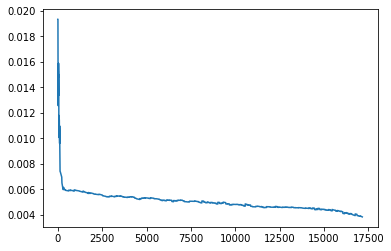

0.0038353605195879936


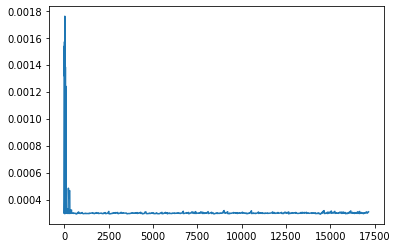

0.0002935150114353746


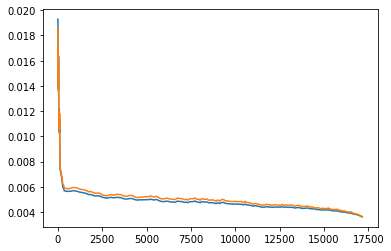

train: 0.0036041862331330776 test: 0.0036348472349345684
0.8492889859188146 tensor(0.0207, device='cuda:0', grad_fn=<MseLossBackward>) tensor(0.0006, device='cuda:0', grad_fn=<MseLossBackward>)


In [24]:
plt.plot(cpn_losses)
plt.show()
print(min(cpn_losses))

plt.plot(pred_losses)
plt.show()
print(min(pred_losses))

plt.plot(real_losses)
plt.plot(test_losses)
plt.show()
print("train:", min(real_losses), "test:", min(test_losses))

mrl = min(real_losses)
dh = mrl - comp_loss_healthy.item()
dl = comp_loss_lesioned.item() - comp_loss_healthy.item()
recov_pct = 1.0 - (dh / dl)
print(recov_pct, comp_loss_lesioned, comp_loss_healthy)

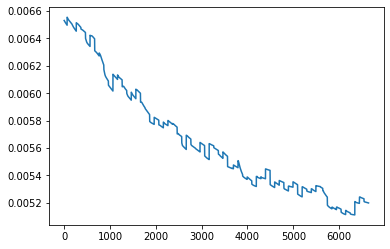

0.005112622398883104


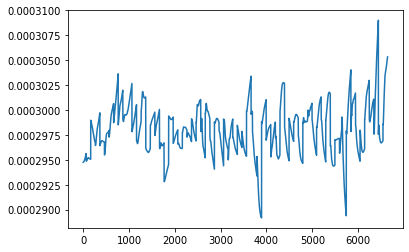

0.00023619270359631628


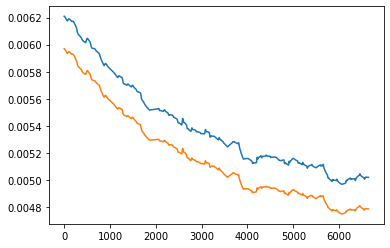

train: 0.004968496970832348 test: 0.004749489016830921
0.7816155845283448 tensor(0.0207, device='cuda:0', grad_fn=<MseLossBackward>) tensor(0.0006, device='cuda:0', grad_fn=<MseLossBackward>)


In [15]:
plt.plot(cpn_losses[1500:])
plt.show()
print(min(cpn_losses))

plt.plot(pred_losses[1500:])
plt.show()
print(min(pred_losses))

plt.plot(real_losses[1500:])
plt.plot(test_losses[1500:])
plt.show()
print("train:", min(real_losses), "test:", min(test_losses))

mrl = min(real_losses)
dh = mrl - comp_loss_healthy.item()
dl = comp_loss_lesioned.item() - comp_loss_healthy.item()
recov_pct = 1.0 - (dh / dl)
print(recov_pct, comp_loss_lesioned, comp_loss_healthy)

In [26]:
# TODO: get a CPN collection and explore the impact of the level of noise we are using.
# TODO: look for classes or data points we suck at
# TODO: train vs test
# TODO: deep dive EN grads bad

print(recent_losses)

[0.012536630965769291, 0.012541639618575573]


torch.Size([1, 341, 50])


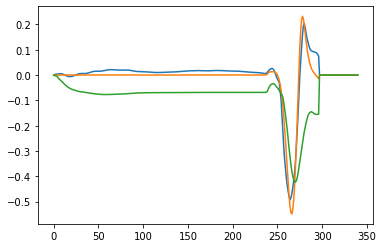

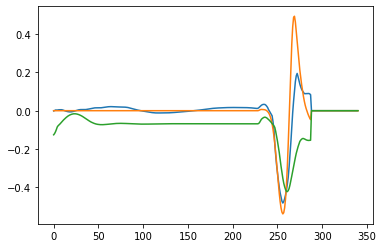

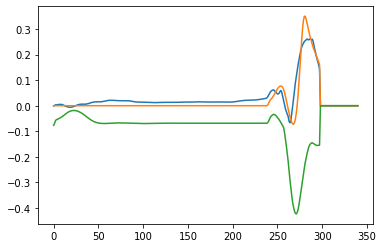

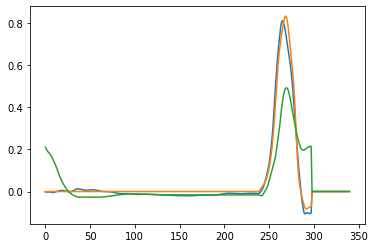

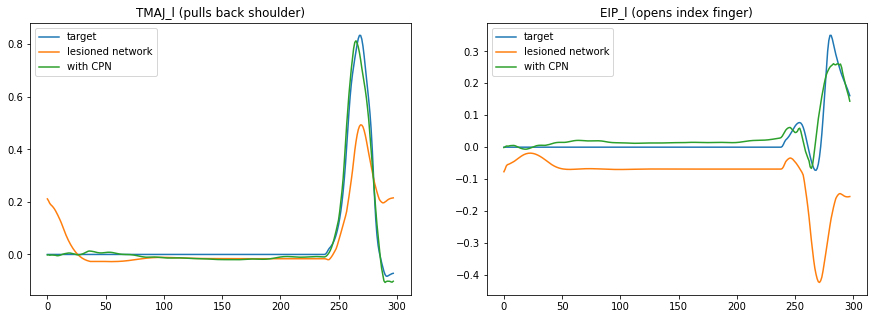

In [89]:
mike.reset()
reference_pred_lesioned_0 = mike.unroll(din[0, :, :].T, cuda=CUDA)
reference_pred_lesioned_neg1 = mike.unroll(din[-1, :, :].T, cuda=CUDA)
reference_pred_lesioned_20 = mike.unroll(din[20, :, :].T, cuda=CUDA)
mike.reset()

reference_pred_lesioned_0 = utils.trunc_to_trial_end(reference_pred_lesioned_0, trial_end[0, :])
reference_pred_lesioned_neg1 = utils.trunc_to_trial_end(reference_pred_lesioned_neg1, trial_end[-1, :])
reference_pred_lesioned_20 = utils.trunc_to_trial_end(reference_pred_lesioned_20, trial_end[20, :])


print(reference_pred_lesioned_0.shape)


#plt.plot(preds[0, :, 45].cpu().detach().numpy())
#plt.plot(preds.grad[0, :, 45].cpu().detach().numpy())
plt.plot(actuals[0, :, 45].cpu().detach().numpy())
plt.plot(dout[0, :, 45].cpu().detach().numpy())
plt.plot(reference_pred_lesioned_0[0, :, 45].cpu().detach().numpy())
plt.show()

#plt.plot(preds[-1, :, 45].cpu().detach().numpy())
plt.plot(actuals[-1, :, 45].cpu().detach().numpy())
plt.plot(dout[-1, :, 45].cpu().detach().numpy())
plt.plot(reference_pred_lesioned_neg1[0, :, 45].cpu().detach().numpy())
plt.show()

#plt.plot(preds[20, :, 45].cpu().detach().numpy())
plt.plot(actuals[20, :, 45].cpu().detach().numpy())
plt.plot(dout[20, :, 45].cpu().detach().numpy())
plt.plot(reference_pred_lesioned_20[0, :, 45].cpu().detach().numpy())
plt.show()

#plt.plot(preds[20, :, 7].cpu().detach().numpy())
plt.plot(actuals[20, :, 7].cpu().detach().numpy())
plt.plot(dout[20, :, 7].cpu().detach().numpy())
plt.plot(reference_pred_lesioned_20[0, :, 7].cpu().detach().numpy())
plt.show()


fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].set_title("TMAJ_l (pulls back shoulder)")
ax[0].plot(dout[20, :trial_len[20], 7].cpu().detach().numpy(), label="target")
ax[0].plot(reference_pred_lesioned_20[0, :trial_len[20], 7].cpu().detach().numpy(), label="lesioned network")
ax[0].plot(actuals[20, :trial_len[20], 7].cpu().detach().numpy(), label="with CPN")
ax[0].legend(loc="upper left")
ax[1].set_title("EIP_l (opens index finger)")
ax[1].plot(dout[20, :trial_len[20], 45].cpu().detach().numpy(), label="target")
ax[1].plot(reference_pred_lesioned_20[0, :trial_len[20], 45].cpu().detach().numpy(), label="lesioned network")
ax[1].plot(actuals[20, :trial_len[20], 45].cpu().detach().numpy(), label="with CPN")
ax[1].legend(loc="upper left")

plt.show()

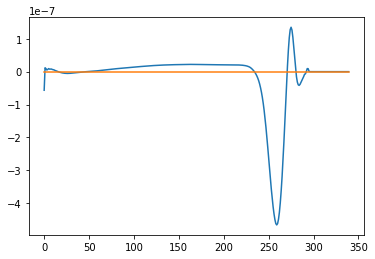

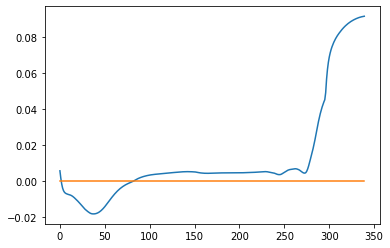

IndexError: index 20 is out of bounds for dimension 1 with size 16

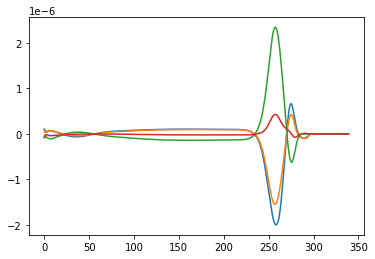

In [16]:
ss = [x[20, 6].item() for x in stims]
gg = [x.grad[20, 6].item() for x in stims]
ref = [0.0 for x in stims]

plt.plot(gg)
plt.plot(ref)
plt.show()
plt.plot(ss)
plt.plot(ref)
plt.show()

for idx in range(0, 25, 5):
    gg = [x.grad[20, idx].item() for x in stims]
    plt.plot(gg)
plt.show()

# On bad run: gradient is negative when values are too high

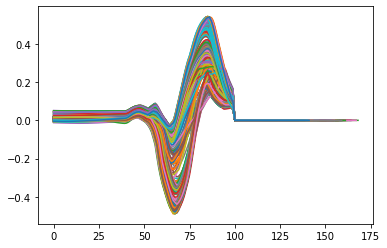

In [63]:
# Are gestures taken between classes?
stout = []
bsize = actuals.shape[0]

for bidx in range(bsize):
    stout.append(actuals[bidx, (trial_len[bidx].item()-100):, 45].cpu().detach().numpy())

for i in range(bidx):
    plt.plot(stout[i])
    
plt.show()

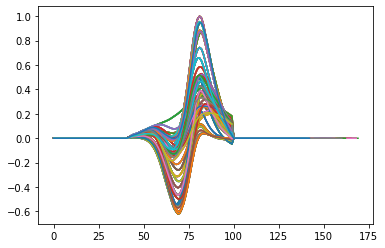

In [64]:
# How does that compare to targets?
stout = []
bsize = dout.shape[0]
for bidx in range(bsize):
    stout.append(dout[bidx, (trial_len[bidx].item()-100):, 45].cpu().detach().numpy())

for i in range(bidx):
    plt.plot(stout[i])
    
plt.show()